## **Deteksi Kanker Payudara Pada Citra Ultrasografi menggunakan Metode Neural Network dengan Ekstraksi Fitur Gray Level Cooccurrence Matrix (GLCM) dan Optimasi Fungsi Aktivasi ReLU Dan Adam**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **PRE-PROCESSING**

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.stats import entropy
import pandas as pd


def preprocessing_ultrasound(image_path, output_folder):
    # Baca citra ultrasonografi
    image_ori = cv2.imread(image_path)

    # Konversi citra menjadi grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 1. Pengurangan noise dengan Gaussian Blur
    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # 2. Thresholding untuk menghasilkan binary mask
    _, thresh = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY_INV)

    # 3. Temukan kontur pada clean mask
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Inisialisasi variabel untuk kontur dengan area terbesar di luar area
    largest_contour_above = None
    largest_area_above = 0

    # Loop melalui semua kontur
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > largest_area_above:
            # Periksa apakah kontur berada di luar area bawah gambar
            if cv2.pointPolygonTest(contour, (image.shape[1] / 2, image.shape[0]), False) < 0:
                largest_area_above = area
                largest_contour_above = contour

    # Buat citra hitam kosong
    output_mask = np.zeros_like(thresh)

    if largest_contour_above is not None:
        # Gambar kontur dengan area terbesar di luar area bawah pada citra output
        cv2.drawContours(output_mask, [largest_contour_above], -1, (255), thickness=cv2.FILLED)

        # Menampilkan hasil preprocessing
        plt.figure(figsize=(10, 10))
        plt.subplot(231), plt.imshow(image_ori, cmap='gray'), plt.title('Citra Asli')
        # plt.subplot(232), plt.imshow(image, cmap='gray'), plt.title('Grayscale')
        # plt.subplot(233), plt.imshow(blurred, cmap='gray'), plt.title('Gaussian Blur')
        plt.subplot(232), plt.imshow(output_mask, cmap='gray'), plt.title('Thresholding')

    if largest_contour_above is not None:
        # Gambar kontur dengan area terbesar di luar area bawah pada citra asli
        image_with_largest_contour = cv2.drawContours(image, [largest_contour_above], -1, (0, 255, 0), 2)
        # plt.subplot(235), plt.imshow(image_with_largest_contour, cmap='gray'), plt.title('Kontur')


    plt.show()

   # Menyimpan hasil output_mask ke folder output di Google Drive
    output_image_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_image_path, output_mask)

    return thresh  # Mengembalikan hasil akhir yang ingin digunakan

def clear_output_folder(output_folder):
    # Hapus semua file dalam folder output
    for filename in os.listdir(output_folder):
        file_path = os.path.join(output_folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f'Gagal menghapus {file_path}. Reason: {e}')

print('---------------------Abnormal-Aug---------------------')
print(' ')
print(' ')

# Path ke folder berisi gambar citra ultrasonografi kanker payudara
input_folder_path = '/content/drive/My Drive/Colab Notebooks/DeteksiKanker/Dataset/abnormal-aug/'
output_folder_path = '/content/drive/My Drive/Colab Notebooks/DeteksiKanker/Dataset/preprop-abnormal/'  # Ganti dengan jalur folder Anda

# Pastikan folder output ada
os.makedirs(output_folder_path, exist_ok=True)

# Bersihkan folder output sebelum mulai menyimpan hasil baru
clear_output_folder(output_folder_path)

# List semua file dalam folder
image_files = os.listdir(input_folder_path)

# Iterasi melalui setiap gambar di folder
for image_file in image_files:
    # Menggabungkan path folder dengan nama file
    input_image_path = os.path.join(input_folder_path, image_file)

    # Melakukan preprocessing pada setiap gambar
    output_mask = preprocessing_ultrasound(input_image_path, output_folder_path)

print('---------------------Normal-Aug---------------------')
print(' ')
print(' ')
# Path ke folder berisi gambar citra ultrasonografi kanker payudara
input_folder_path2 = '/content/drive/My Drive/Colab Notebooks/DeteksiKanker/Dataset/normal-aug/'
output_folder_path2 = '/content/drive/My Drive/Colab Notebooks/DeteksiKanker/Dataset/preprop-normal/' # Ganti dengan jalur folder Anda

# Pastikan folder output ada
os.makedirs(output_folder_path2, exist_ok=True)

# Bersihkan folder output sebelum mulai menyimpan hasil baru
clear_output_folder(output_folder_path2)

# List semua file dalam folder
image_files2 = os.listdir(input_folder_path2)

# Iterasi melalui setiap gambar di folder
for image_file2 in image_files2:
    # Menggabungkan path folder dengan nama file
    input_image_path2 = os.path.join(input_folder_path2, image_file2)

    # Melakukan preprocessing pada setiap gambar
    output_mask2 = preprocessing_ultrasound(input_image_path2, output_folder_path2)

Output hidden; open in https://colab.research.google.com to view.

### **Fungsi Ektraksi GLCM**

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os

# Fungsi untuk menghitung GLCM
def calculate_glcm(image, distances=[1], angles=[0], levels=256):
    # Initialize GLCM matrices
    glcm_matrices = []

    for distance in distances:
        for angle in angles:
            # Calculate offset
            offset_x = int(distance * np.cos(angle))
            offset_y = int(distance * np.sin(angle))

            # Initialize GLCM matrix
            glcm = np.zeros((levels, levels), dtype=np.uint32)

            # Loop through image pixels
            for y in range(image.shape[0]):
                for x in range(image.shape[1]):
                    x_neighbor = x + offset_x
                    y_neighbor = y + offset_y

                    # Ensure neighbor is within image bounds
                    if 0 <= x_neighbor < image.shape[1] and 0 <= y_neighbor < image.shape[0]:
                        intensity_i = image[y, x]
                        intensity_j = image[y_neighbor, x_neighbor]
                        glcm[intensity_i, intensity_j] += 1

            # Normalize GLCM
            glcm = glcm.astype(np.float32) / np.sum(glcm)
            glcm_matrices.append(glcm)

    return glcm_matrices

# Fungsi untuk menghitung energi GLCM
def calculate_energy(glcm):
    return np.sum(glcm**2)

# Fungsi untuk menghitung kontrast GLCM
def calculate_contrast(glcm):
    contrast = 0
    levels = glcm.shape[0]
    for i in range(levels):
        for j in range(levels):
            contrast += (i - j)**2 * glcm[i, j]
    return contrast

# Fungsi untuk menghitung homogenitas GLCM
def calculate_homogeneity(glcm):
    homogeneity = 0
    levels = glcm.shape[0]
    for i in range(levels):
        for j in range(levels):
            homogeneity += glcm[i, j] / (1 + abs(i - j))
    return homogeneity

# Fungsi untuk menghitung entropi GLCM
def calculate_entropy(glcm):
    return -np.sum(glcm * np.log2(glcm + np.finfo(float).eps))

## Ekstraksi Fitur Abnormal (Kanker)

In [ ]:
from scipy.stats import entropy

# Path ke direktori gambar
image_directory = '/content/drive/My Drive/Colab Notebooks/DeteksiKanker/Dataset/preprop-abnormal/'

# List untuk menyimpan hasil fitur GLCM
glcm_features_list_abnormal = []

# Iterasi melalui semua file dalam direktori
for filename in os.listdir(image_directory):
    if filename.endswith(".png"):  # Pastikan hanya file berformat .png yang diambil
        # Load citra dari file
        image_path = os.path.join(image_directory, filename)
        usg_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Pastikan citra berhasil dimuat
        if usg_image is not None:
            # Hitung GLCM dan fitur tekstur
            glcm_matrices = calculate_glcm(usg_image, distances=[1], angles=[0], levels=256)

            # Hitung fitur tekstur untuk setiap GLCM matrix
            for i, glcm in enumerate(glcm_matrices):
                energy = calculate_energy(glcm)
                contrast = calculate_contrast(glcm)
                homogeneity = calculate_homogeneity(glcm)
                entropy = calculate_entropy(glcm)

                # Simpan fitur dalam bentuk dictionary
                glcm_features = {
                    'Energy': energy,
                    'Contrast': contrast,
                    'Homogeneity': homogeneity,
                    'Entropy': entropy,
                    'Label': '1'
                }

                # Tambahkan ke list hasil
                glcm_features_list_abnormal.append(glcm_features)

# Buat DataFrame dari list fitur GLCM
data_glcm_abnormal = pd.DataFrame(glcm_features_list_abnormal)


# Simpan DataFrame ke dalam file CSV
# csv_filename = 'glcm_abnormal.csv'
# data1.to_csv(csv_filename, index=False)

# Tampilkan DataFrame
print(data_glcm_abnormal)

# Tampilkan pesan sukses
# print(f"Hasil ekstraksi fitur GLCM telah disimpan dalam file {csv_filename}")


      Energy    Contrast  Homogeneity   Entropy Label
0   1.000000    0.000000     1.000000 -0.000000     1
1   0.995617   33.918714     0.999480  0.024808     1
2   1.000000    0.000000     1.000000 -0.000000     1
3   0.959669   93.025753     0.998575  0.153498     1
4   0.997171   16.606882     0.999746  0.016664     1
..       ...         ...          ...       ...   ...
95  0.984738  134.245157     0.997944  0.073481     1
96  0.497014  424.303279     0.993500  1.051655     1
97  0.998589   11.975139     0.999817  0.009177     1
98  0.495454  420.783003     0.993554  1.053248     1
99  0.725243  438.048979     0.993290  0.688242     1

[100 rows x 5 columns]


In [ ]:
from scipy.stats import entropy

# Inisialisasi list untuk menyimpan fitur
feature_list_abnormal = []

# Iterasi melalui semua file dalam direktori
for filename in os.listdir(image_directory):
    if filename.endswith(".png"):  # Pastikan hanya file berformat .png yang diambil
        # Load citra dari file
        image_path = os.path.join(image_directory, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Pastikan citra berhasil dimuat
        if image is not None:
            # Hitung 'Energy'
            energy = np.sum(image ** 2)

            # Hitung 'Contrast' (varians)
            contrast = np.var(image)

            # Hitung 'Homogeneity'
            diffs = np.diff(image.astype(np.float32), axis=0)
            homogeneity = np.mean(1 / (1 + np.abs(diffs)))

            # Hitung 'Entropy'
            hist, _ = np.histogram(image, bins=256, range=[0, 256], density=True)
            hist += 1e-10  # Hindari nilai nol untuk perhitungan entropy
            ent = entropy(hist)

            # Simpan fitur dalam bentuk dictionary
            features = {
                'Energy': energy,
                'Contrast': contrast,
                'Homogeneity': homogeneity,
                'Entropy': ent,
                'Label': '1'  # Sesuaikan label sesuai kebutuhan
            }

            # Tambahkan ke list hasil
            feature_list_abnormal.append(features)


# Buat DataFrame dari list fitur
data_non_glcm_abnormal = pd.DataFrame(feature_list_abnormal)

# Tampilkan DataFrame
print(data_non_glcm_abnormal)


    Energy      Contrast  Homogeneity       Entropy Label
0        0      0.000000     1.000000  6.126592e-07     1
1       89    124.955814     0.999134  1.396273e-02     1
2        0      0.000000     1.000000  6.126592e-07     1
3     1082   1259.528949     0.997954  9.710574e-02     1
4      111     83.397034     0.999607  9.833615e-03     1
..     ...           ...          ...           ...   ...
95     103    425.819173     0.997944  3.967519e-02     1
96   42804  16136.755094     0.986019  6.894679e-01     1
97      20     39.672356     0.999511  5.129243e-03     1
98   43601  16192.553643     0.988140  6.911874e-01     1
99    9847   8687.094244     0.990612  4.377086e-01     1

[100 rows x 5 columns]


## Ekstraksi Fitur Normal (Non- Kanker)

In [ ]:
# Path ke direktori gambar
image_directory2 = '/content/drive/My Drive/Colab Notebooks/DeteksiKanker/Dataset/preprop-normal/'

# List untuk menyimpan hasil fitur GLCM
glcm_features_list2 = []

# Iterasi melalui semua file dalam direktori
for filename in os.listdir(image_directory2):
    if filename.endswith(".png"):  # Pastikan hanya file berformat .png yang diambil
        # Load citra dari file
        image_path = os.path.join(image_directory2, filename)
        usg_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Pastikan citra berhasil dimuat
        if usg_image is not None:
            # Hitung GLCM dan fitur tekstur
            glcm_matrices = calculate_glcm(usg_image, distances=[1], angles=[0], levels=256)

            # Hitung fitur tekstur untuk setiap GLCM matrix
            for i, glcm in enumerate(glcm_matrices):
                energy = calculate_energy(glcm)
                contrast = calculate_contrast(glcm)
                entropy = calculate_entropy(glcm)

                # Simpan fitur dalam bentuk dictionary
                glcm_features = {
                    'Energy': energy,
                    'Contrast': contrast,
                    'Homogeneity': homogeneity,
                    'Entropy': entropy,
                    'Label': '0'
                }

                # Tambahkan ke list hasil
                glcm_features_list2.append(glcm_features)

# Buat DataFrame dari list fitur GLCM
data_glcm_normal = pd.DataFrame(glcm_features_list2)

# # Simpan DataFrame ke dalam file CSV
# csv_filename = 'glcm_normal.csv'
# data0.to_csv(csv_filename, index=False)

# # Tampilkan DataFrame
print(data_glcm_normal)

# # Tampilkan pesan sukses
# print(f"Hasil ekstraksi fitur GLCM telah disimpan dalam file {csv_filename}")


      Energy   Contrast  Homogeneity       Entropy Label
0   1.000000   0.000000     0.990612 -3.203427e-16     0
1   1.000000   0.000000     0.990612 -0.000000e+00     0
2   1.000000   0.000000     0.990612 -3.203427e-16     0
3   0.998457  18.070867     0.990612  1.010033e-02     0
4   0.997980   7.935408     0.990612  1.212829e-02     0
..       ...        ...          ...           ...   ...
95  1.000000   0.000000     0.990612 -0.000000e+00     0
96  1.000000   0.000000     0.990612 -0.000000e+00     0
97  1.000000   0.000000     0.990612 -0.000000e+00     0
98  0.999690   6.054469     0.990612  2.338226e-03     0
99  1.000000   0.000000     0.990612 -0.000000e+00     0

[100 rows x 5 columns]


In [ ]:
from scipy.stats import entropy

feature_list_normal = []


# Iterasi melalui semua file dalam direktori
for filename in os.listdir(image_directory2):
    if filename.endswith(".png"):  # Pastikan hanya file berformat .png yang diambil
        # Load citra dari file
        image_path = os.path.join(image_directory2, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Pastikan citra berhasil dimuat
        if image is not None:
            # Hitung 'Energy'
            energy = np.sum(image ** 2)

            # Hitung 'Contrast' (varians)
            contrast = np.var(image)

            # Hitung 'Homogeneity'
            diffs = np.diff(image.astype(np.float32), axis=0)
            homogeneity = np.mean(1 / (1 + np.abs(diffs)))

            # Hitung 'Entropy'
            hist, _ = np.histogram(image, bins=256, range=[0, 256], density=True)
            hist += 1e-10  # Hindari nilai nol untuk perhitungan entropy
            ent = entropy(hist)

            # Simpan fitur dalam bentuk dictionary
            features = {
                'Energy': energy,
                'Contrast': contrast,
                'Homogeneity': homogeneity,
                'Entropy': ent,
                'Label': '0'  # Sesuaikan label sesuai kebutuhan
            }

            # Tambahkan ke list hasil
            feature_list_normal.append(features)


# Buat DataFrame dari list fitur
data_non_glcm_normal = pd.DataFrame(feature_list_normal)

print(data_non_glcm_normal)

    Energy   Contrast  Homogeneity       Entropy Label
0        0   0.000000     1.000000  6.126592e-07     0
1        0   0.000000     1.000000  6.126592e-07     0
2        0   0.000000     1.000000  6.126592e-07     0
3       41  40.974148     0.999539  5.277262e-03     0
4       57  64.283979     0.999444  7.835866e-03     0
..     ...        ...          ...           ...   ...
95       0   0.000000     1.000000  6.126592e-07     0
96       0   0.000000     1.000000  6.126592e-07     0
97       0   0.000000     1.000000  6.126592e-07     0
98       5  10.033174     0.999876  1.509315e-03     0
99       0   0.000000     1.000000  6.126592e-07     0

[100 rows x 5 columns]


In [ ]:
# # Unduh hasil GLCM
# from google.colab import files

# csv_filename = 'glcm_abnormal.csv'

# # Unduh file CSV
# files.download(csv_filename)

# Implementation ANN

## Prossed Data For Neural Network (**Backpropagation**)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
dataset_glcm = pd.concat([data_glcm_abnormal, data_glcm_normal ], ignore_index=True)
dataset_non_glcm =  pd.concat([data_non_glcm_abnormal, data_non_glcm_normal ], ignore_index=True)
print(dataset_glcm)
print(dataset_non_glcm)

       Energy   Contrast  Homogeneity   Entropy Label
0    1.000000   0.000000     1.000000 -0.000000     1
1    0.995617  33.918714     0.999480  0.024808     1
2    1.000000   0.000000     1.000000 -0.000000     1
3    0.959669  93.025753     0.998575  0.153498     1
4    0.997171  16.606882     0.999746  0.016664     1
..        ...        ...          ...       ...   ...
195  1.000000   0.000000     0.990612 -0.000000     0
196  1.000000   0.000000     0.990612 -0.000000     0
197  1.000000   0.000000     0.990612 -0.000000     0
198  0.999690   6.054469     0.990612  0.002338     0
199  1.000000   0.000000     0.990612 -0.000000     0

[200 rows x 5 columns]
     Energy     Contrast  Homogeneity       Entropy Label
0         0     0.000000     1.000000  6.126592e-07     1
1        89   124.955814     0.999134  1.396273e-02     1
2         0     0.000000     1.000000  6.126592e-07     1
3      1082  1259.528949     0.997954  9.710574e-02     1
4       111    83.397034     0.999607 

In [ ]:
# # Gabungkan kedua dataset
# dataset = pd.concat([dt1, dt2], ignore_index=True)

# # Simpan dataset gabungan ke dalam file CSV
# dataset.to_csv("dataset.csv", index=False)

# # Mengacak seluruh DataFrame =1 artinya mengacak 100%, cth. 0,5 brrti 50% data
# df = dataset.sample(frac=1)


In [ ]:
# # # Gabungkan kedua dataset
# dataset = pd.concat([data0, data1], ignore_index=True)
# print(dataset)

In [ ]:
dfg = dataset_glcm
dfg

,Energy,Contrast,Homogeneity,Entropy,Label
0,1.000000,0.000000,1.000000,-0.000000,1
1,0.995617,33.918714,0.999480,0.024808,1
2,1.000000,0.000000,1.000000,-0.000000,1
3,0.959669,93.025753,0.998575,0.153498,1
4,0.997171,16.606882,0.999746,0.016664,1
...,...,...,...,...,...
195,1.000000,0.000000,0.990612,-0.000000,0
196,1.000000,0.000000,0.990612,-0.000000,0
197,1.000000,0.000000,0.990612,-0.000000,0
198,0.999690,6.054469,0.990612,0.002338,0


In [ ]:
dfng = dataset_non_glcm
dfng

,Energy,Contrast,Homogeneity,Entropy,Label
0,0,0.000000,1.000000,6.126592e-07,1
1,89,124.955814,0.999134,1.396273e-02,1
2,0,0.000000,1.000000,6.126592e-07,1
3,1082,1259.528949,0.997954,9.710574e-02,1
4,111,83.397034,0.999607,9.833615e-03,1
...,...,...,...,...,...
195,0,0.000000,1.000000,6.126592e-07,0
196,0,0.000000,1.000000,6.126592e-07,0
197,0,0.000000,1.000000,6.126592e-07,0
198,5,10.033174,0.999876,1.509315e-03,0


In [ ]:
dfg['Label'] = dfg['Label'].astype(int)
dfg.dtypes

Energy         float64
Contrast       float64
Homogeneity    float64
Entropy        float64
Label            int64
dtype: object

In [ ]:
dfng['Label'] = dfng['Label'].astype(int)
dfng['Energy'] = dfng['Energy'].astype(float)
dfng.dtypes

Energy         float64
Contrast       float64
Homogeneity    float32
Entropy        float64
Label            int64
dtype: object

In [ ]:
# Memisahkan variabel prediksi dan yang sudah diprediksi
feature_dfg=dfg[['Energy', 'Contrast', 'Homogeneity', 'Entropy']]
x_g = np.asarray(feature_dfg)
y_g = np.asarray(dfg['Label'])

In [ ]:
# Memisahkan variabel prediksi dan yang sudah diprediksi
feature_dfng=dfng[['Energy', 'Contrast', 'Homogeneity', 'Entropy']]
x_ng = np.asarray(feature_dfng)
y_ng = np.asarray(dfng['Label'])

In [ ]:
y_g

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [ ]:
from sklearn.model_selection import train_test_split

# split data
x_train_g, x_test_g, y_train_g, y_test_g = train_test_split(x_g, y_g, test_size=0.3, random_state=2)

# split data
x_train_ng, x_test_ng, y_train_ng, y_test_ng = train_test_split(x_ng, y_ng, test_size=0.3, random_state=2)

In [ ]:
#Menampilkan ukuran data
print(x_g.shape, x_train_g.shape, x_test_g.shape)

#Menampilkan ukuran data
print(x_ng.shape, x_train_ng.shape, x_test_ng.shape)

(200, 4) (140, 4) (60, 4)
(200, 4) (140, 4) (60, 4)


## Nomalisasi Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Normalisasi dengan Min-Max Scaling
x_train_std_g = scaler.fit_transform(x_train_g)
x_test_std_g = scaler.transform(x_test_g)

# Normalisasi dengan Min-Max Scaling
x_train_std_ng = scaler.fit_transform(x_train_ng)
x_test_std_ng = scaler.transform(x_test_ng)

print(x_train_g)
print("---------------------------------------------")
print(x_test_g)
print("---------------------------------------------")
print(x_train_ng)
print("---------------------------------------------")
print(x_test_ng)

[[ 7.10049943e-01  1.57090305e+02  9.97593592e-01  6.90446763e-01]
 [ 9.97295637e-01  1.89854015e+01  9.90612030e-01  1.61609573e-02]
 [ 9.97027636e-01  2.65072760e+01  9.99593947e-01  1.77882891e-02]
 [ 9.37092656e-01  1.19020744e+02  9.98176766e-01  2.18519944e-01]
 [ 1.00000000e+00  0.00000000e+00  9.90612030e-01 -0.00000000e+00]
 [ 9.96053696e-01  3.05971203e+01  9.99531268e-01  2.26368308e-02]
 [ 9.99867878e-01  1.71832884e+00  9.90612030e-01  1.10322992e-03]
 [ 1.00000000e+00  0.00000000e+00  9.90612030e-01 -0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  9.90612030e-01 -0.00000000e+00]
 [ 9.99397369e-01  6.53254973e+00  9.90612030e-01  4.23654961e-03]
 [ 1.00000000e+00  0.00000000e+00  9.90612030e-01 -0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  9.90612030e-01 -0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  9.90612030e-01 -3.20342650e-16]
 [ 7.44757189e-01  2.92979640e+02  9.95511954e-01  6.41582709e-01]
 [ 9.95617390e-01  3.39187138e+01  9.99480407e-01  2.48082243e

## Perhitungan METODE Neural Network (Backpropagation)

In [ ]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Inisialisasi weights dan biases
        self.weights_input_hidden = np.random.rand(input_size, hidden_size)
        self.biases_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.rand(hidden_size, output_size)
        self.biases_output = np.zeros((1, output_size))

    def sigmoid(self, x):
        # Fungsi aktivasi sigmoid
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        # Turunan fungsi sigmoid
        return x * (1 - x)

    def forward(self, inputs):
        # forward propagation
        self.hidden_layer_input = np.dot(inputs, self.weights_input_hidden) + self.biases_hidden
        self.hidden_layer_output = self.sigmoid(self.hidden_layer_input)

        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.biases_output
        self.predicted_output = self.sigmoid(self.output_layer_input)

        return self.predicted_output

    def backward(self, inputs, targets, learning_rate):
        # Menghitung error
        output_error = targets - self.predicted_output
        output_delta = output_error * self.sigmoid_derivative(self.predicted_output)

        # Menghitung error di hidden layer
        hidden_layer_error = output_delta.dot(self.weights_hidden_output.T)
        hidden_layer_delta = hidden_layer_error * self.sigmoid_derivative(self.hidden_layer_output)

        # Update weights dan biases
        self.weights_hidden_output += self.hidden_layer_output.T.dot(output_delta) * learning_rate
        self.biases_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden += inputs.T.dot(hidden_layer_delta) * learning_rate
        self.biases_hidden += np.sum(hidden_layer_delta, axis=0, keepdims=True) * learning_rate

    def train(self, inputs, targets, epochs, learning_rate, tolerance=1e-5):
        mses = []  # List untuk menyimpan nilai loss pada setiap epoch
        prev_loss = float('inf')  # Inisialisasi nilai loss sebelumnya dengan infinitas
        for epoch in range(epochs):
            temp_mses = []  # List sementara untuk menyimpan nilai loss pada setiap data pelatihan dalam satu epoch
            # Lakukan forward dan backward propagation untuk setiap epoch
            for i in range(len(inputs)):
                input_data = inputs[i:i+1]
                target = targets[i:i+1]
                self.forward(input_data)
                self.backward(input_data, target, learning_rate)
                # Hitung error dan tambahkan ke list sementara
                loss = np.mean(np.square(target - self.predicted_output))
                temp_mses.append(loss)
            # Hitung rata-rata loss dari semua data pelatihan dalam satu epoch
            epoch_loss = sum(temp_mses) / len(temp_mses)
            mses.append(epoch_loss)

            # Cetak informasi mengenai iterasi epoch
            print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

            # Berhenti jika perbedaan antara loss saat ini dan sebelumnya lebih kecil dari tolerance
            if abs(epoch_loss - prev_loss) < tolerance:
                print(f'Training converged at epoch {epoch + 1}')
                break
            prev_loss = epoch_loss
        return mses

## Perhitungan METODE Neural Network (Backpropagation) With Relu

In [ ]:
class NeuralNetworkWithRelu:
    def __init__(self, input_size, hidden_size, output_size):
        # Inisialisasi weights dan biases dengan distribusi normal
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.biases_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.biases_output = np.zeros((1, output_size))

    def relu(self, x):
        # Fungsi aktivasi ReLU: max(0, x)
        return np.maximum(0, x)

    def relu_derivative(self, x):
        # Turunan fungsi ReLU: 1 jika x > 0, lainnya 0
        return (x > 0).astype(float)

    def forward(self, inputs):
        # Forward propagation menggunakan ReLU
        self.hidden_layer_input = np.dot(inputs, self.weights_input_hidden) + self.biases_hidden
        self.hidden_layer_output = self.relu(self.hidden_layer_input)

        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.biases_output
        self.predicted_output = self.relu(self.output_layer_input)  # Misalnya, output layer juga menggunakan ReLU

        return self.predicted_output

    def backward(self, inputs, targets, learning_rate):
        # Menghitung error
        output_error = targets - self.predicted_output
        output_delta = output_error * self.relu_derivative(self.predicted_output)

        # Menghitung error di hidden layer
        hidden_layer_error = output_delta.dot(self.weights_hidden_output.T)
        hidden_layer_delta = hidden_layer_error * self.relu_derivative(self.hidden_layer_output)

        # Update weights dan biases
        self.weights_hidden_output += self.hidden_layer_output.T.dot(output_delta) * learning_rate
        self.biases_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden += inputs.T.dot(hidden_layer_delta) * learning_rate
        self.biases_hidden += np.sum(hidden_layer_delta, axis=0, keepdims=True) * learning_rate

    def train(self, inputs, targets, epochs, learning_rate, tolerance=1e-5):
        mses = []  # List untuk menyimpan nilai loss pada setiap epoch
        prev_loss = float('inf')  # Inisialisasi nilai loss sebelumnya dengan infinitas
        for epoch in range(epochs):
            temp_mses = []  # List sementara untuk menyimpan nilai loss pada setiap data pelatihan dalam satu epoch
            # Lakukan forward dan backward propagation untuk setiap epoch
            for i in range(len(inputs)):
                input_data = inputs[i:i+1]
                target = targets[i:i+1]
                self.forward(input_data)
                self.backward(input_data, target, learning_rate)
                # Hitung error dan tambahkan ke list sementara
                loss = np.mean(np.square(target - self.predicted_output))
                temp_mses.append(loss)
            # Hitung rata-rata loss dari semua data pelatihan dalam satu epoch
            epoch_loss = sum(temp_mses) / len(temp_mses)
            mses.append(epoch_loss)

            # Cetak informasi mengenai iterasi epoch
            print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

            # Berhenti jika perbedaan antara loss saat ini dan sebelumnya lebih kecil dari tolerance
            if abs(epoch_loss - prev_loss) < tolerance:
                print(f'Training converged at epoch {epoch + 1}')
                break
            prev_loss = epoch_loss
        return mses

## Perhitungan METODE Neural Network (Backpropagation) With Adam

In [ ]:
class NeuralNetworkWithAdam:
    def __init__(self, input_size, hidden_size, output_size):
        # Inisialisasi weights dan biases
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.biases_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
        self.biases_output = np.zeros((1, output_size))

        # Inisialisasi parameter untuk Adam optimizer
        self.m_wih = np.zeros_like(self.weights_input_hidden)
        self.v_wih = np.zeros_like(self.weights_input_hidden)
        self.m_bih = np.zeros_like(self.biases_hidden)
        self.v_bih = np.zeros_like(self.biases_hidden)
        self.m_who = np.zeros_like(self.weights_hidden_output)
        self.v_who = np.zeros_like(self.weights_hidden_output)
        self.m_bo = np.zeros_like(self.biases_output)
        self.v_bo = np.zeros_like(self.biases_output)

    def sigmoid(self, x):
        # Fungsi aktivasi sigmoid
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        # Turunan fungsi sigmoid
        return x * (1 - x)

    def forward(self, inputs):
        # forward propagation
        self.hidden_layer_input = np.dot(inputs, self.weights_input_hidden) + self.biases_hidden
        self.hidden_layer_output = self.sigmoid(self.hidden_layer_input)
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.biases_output
        self.predicted_output = self.sigmoid(self.output_layer_input)
        return self.predicted_output

    def backward(self, inputs, targets, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # Backpropagation dengan Adam optimizer
        output_error = targets - self.predicted_output
        output_delta = output_error * self.sigmoid_derivative(self.predicted_output)

        hidden_layer_error = output_delta.dot(self.weights_hidden_output.T)
        hidden_layer_delta = hidden_layer_error * self.sigmoid_derivative(self.hidden_layer_output)

        # Update dengan Adam untuk weights dan biases
        # Gradients for weights and biases
        grad_wih = inputs.T.dot(hidden_layer_delta)
        grad_bih = np.sum(hidden_layer_delta, axis=0, keepdims=True)
        grad_who = self.hidden_layer_output.T.dot(output_delta)
        grad_bo = np.sum(output_delta, axis=0, keepdims=True)

        # Update moment estimates for each set of weights and biases
        self.m_wih = beta1 * self.m_wih + (1 - beta1) * grad_wih
        self.v_wih = beta2 * self.v_wih + (1 - beta2) * (grad_wih ** 2)
        self.m_bih = beta1 * self.m_bih + (1 - beta1) * grad_bih
        self.v_bih = beta2 * self.v_bih + (1 - beta2) * (grad_bih ** 2)

        self.m_who = beta1 * self.m_who + (1 - beta1) * grad_who
        self.v_who = beta2 * self.v_who + (1 - beta2) * (grad_who ** 2)
        self.m_bo = beta1 * self.m_bo + (1 - beta1) * grad_bo
        self.v_bo = beta2 * self.v_bo + (1 - beta2) * (grad_bo ** 2)

        # Correct bias in estimates
        m_wih_hat = self.m_wih / (1 - beta1)
        v_wih_hat = self.v_wih / (1 - beta2)
        m_bih_hat = self.m_bih / (1 - beta1)
        v_bih_hat = self.v_bih / (1 - beta2)

        m_who_hat = self.m_who / (1 - beta1)
        v_who_hat = self.v_who / (1 - beta2)
        m_bo_hat = self.m_bo / (1 - beta1)
        v_bo_hat = self.v_bo / (1 - beta2)

        # Update weights and biases
        self.weights_input_hidden += learning_rate * m_wih_hat / (np.sqrt(v_wih_hat) + epsilon)
        self.biases_hidden += learning_rate * m_bih_hat / (np.sqrt(v_bih_hat) + epsilon)
        self.weights_hidden_output += learning_rate * m_who_hat / (np.sqrt(v_who_hat) + epsilon)
        self.biases_output += learning_rate * m_bo_hat / (np.sqrt(v_bo_hat) + epsilon)

    def train(self, inputs, targets, epochs, learning_rate, tolerance=1e-5):
        mses = []  # List untuk menyimpan nilai loss pada setiap epoch
        prev_loss = float('inf')  # Inisialisasi nilai loss sebelumnya dengan infinitas

        for epoch in range(epochs):
            temp_mses = []  # List sementara untuk menyimpan nilai loss pada setiap data pelatihan dalam satu epoch

            for i in range(len(inputs)):
                input_data = inputs[i:i+1]
                target = targets[i:i+1]

                # Lakukan forward propagation
                self.forward(input_data)

                # Lakukan backward propagation dengan Adam
                self.backward(input_data, target, learning_rate)

                # Hitung error dan tambahkan ke list sementara
                loss = np.mean((target - self.predicted_output) ** 2)
                temp_mses.append(loss)

            # Hitung rata-rata loss dari semua data pelatihan dalam satu epoch
            epoch_loss = np.mean(temp_mses)
            mses.append(epoch_loss)

            # Cetak informasi mengenai iterasi epoch
            print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.6f}')

            # Berhenti jika perbedaan antara loss saat ini dan sebelumnya lebih kecil dari tolerance
            if abs(prev_loss - epoch_loss) < tolerance:
                print(f'Training converged at epoch {epoch + 1}')
                break

            prev_loss = epoch_loss

        return mses


## Model Running NN

In [ ]:
# Inisialisasi model
input_size = 4
hidden_size = 5
output_size = 1
learning_rate = 0.01

## Running Method Neural Network (Backpropagation) with Data GLCM

In [ ]:
model_glcm = NeuralNetwork(input_size, hidden_size, output_size)
errors_glcm = model_glcm.train(x_train_std_g, y_train_g, epochs=5000, learning_rate=learning_rate)

Epoch 1, Loss: 0.3181212668411553
Epoch 2, Loss: 0.2946080028028145
Epoch 3, Loss: 0.27449723100332185
Epoch 4, Loss: 0.25919975705071213
Epoch 5, Loss: 0.24862395487168562
Epoch 6, Loss: 0.24173654490346333
Epoch 7, Loss: 0.23733523925274216
Epoch 8, Loss: 0.2344628014071057
Epoch 9, Loss: 0.23248077440880272
Epoch 10, Loss: 0.23100125638015429
Epoch 11, Loss: 0.22979998080172104
Epoch 12, Loss: 0.2287505028135081
Epoch 13, Loss: 0.22778227793707156
Epoch 14, Loss: 0.2268559846027995
Epoch 15, Loss: 0.22594955872697783
Epoch 16, Loss: 0.2250504466675964
Epoch 17, Loss: 0.2241513480840528
Epoch 18, Loss: 0.22324788393831896
Epoch 19, Loss: 0.22233731763556674
Epoch 20, Loss: 0.22141785052801732
Epoch 21, Loss: 0.220488230853902
Epoch 22, Loss: 0.2195475343345712
Epoch 23, Loss: 0.21859503939111372
Epoch 24, Loss: 0.2176301550127925
Epoch 25, Loss: 0.21665237830100068
Epoch 26, Loss: 0.21566126901378868
Epoch 27, Loss: 0.2146564340444215
Epoch 28, Loss: 0.21363751783897147
Epoch 29, Los

In [ ]:
model2_glcm = NeuralNetwork(input_size, hidden_size, output_size)
errors2_glcm = model2_glcm.train(x_train_std_g, y_train_g, epochs=5000, learning_rate=learning_rate)

Epoch 1, Loss: 0.3368833069339715
Epoch 2, Loss: 0.31149749284705813
Epoch 3, Loss: 0.2882636818558239
Epoch 4, Loss: 0.26962900108183646
Epoch 5, Loss: 0.25636943103824084
Epoch 6, Loss: 0.24771550669092054
Epoch 7, Loss: 0.24230805662360502
Epoch 8, Loss: 0.23892894155790545
Epoch 9, Loss: 0.23673047442014875
Epoch 10, Loss: 0.23519223824635113
Epoch 11, Loss: 0.23401468060789332
Epoch 12, Loss: 0.23303080596713818
Epoch 13, Loss: 0.2321487749389099
Epoch 14, Loss: 0.2313181902776645
Epoch 15, Loss: 0.23051122245229005
Epoch 16, Loss: 0.22971228590493098
Epoch 17, Loss: 0.22891245153921957
Epoch 18, Loss: 0.22810643271969766
Epoch 19, Loss: 0.2272909573469348
Epoch 20, Loss: 0.22646388427308625
Epoch 21, Loss: 0.22562371980846616
Epoch 22, Loss: 0.224769350145717
Epoch 23, Loss: 0.2238998911241063
Epoch 24, Loss: 0.22301460241385304
Epoch 25, Loss: 0.22211283755618058
Epoch 26, Loss: 0.22119401431515553
Epoch 27, Loss: 0.22025759678710513
Epoch 28, Loss: 0.21930308449009753
Epoch 29,

In [ ]:
model3_glcm = NeuralNetworkWithAdam(input_size, hidden_size, output_size)
errors3_glcm = model3_glcm.train(x_train_std_g, y_train_g, epochs=5000, learning_rate=learning_rate)

Epoch 1, Loss: 0.208761
Epoch 2, Loss: 0.121082
Epoch 3, Loss: 0.069298
Epoch 4, Loss: 0.042211
Epoch 5, Loss: 0.027729
Epoch 6, Loss: 0.019320
Epoch 7, Loss: 0.014032
Epoch 8, Loss: 0.010497
Epoch 9, Loss: 0.008039
Epoch 10, Loss: 0.006287
Epoch 11, Loss: 0.005015
Epoch 12, Loss: 0.004073
Epoch 13, Loss: 0.003362
Epoch 14, Loss: 0.002814
Epoch 15, Loss: 0.002384
Epoch 16, Loss: 0.002041
Epoch 17, Loss: 0.001763
Epoch 18, Loss: 0.001535
Epoch 19, Loss: 0.001345
Epoch 20, Loss: 0.001185
Epoch 21, Loss: 0.001050
Epoch 22, Loss: 0.000934
Epoch 23, Loss: 0.000834
Epoch 24, Loss: 0.000748
Epoch 25, Loss: 0.000673
Epoch 26, Loss: 0.000607
Epoch 27, Loss: 0.000548
Epoch 28, Loss: 0.000497
Epoch 29, Loss: 0.000451
Epoch 30, Loss: 0.000411
Epoch 31, Loss: 0.000374
Epoch 32, Loss: 0.000342
Epoch 33, Loss: 0.000312
Epoch 34, Loss: 0.000286
Epoch 35, Loss: 0.000262
Epoch 36, Loss: 0.000240
Epoch 37, Loss: 0.000221
Epoch 38, Loss: 0.000203
Epoch 39, Loss: 0.000187
Epoch 40, Loss: 0.000172
Epoch 41,

## Running Method Neural Network (Backpropagation) with Data Non GLCM

In [ ]:
model_non_glcm = NeuralNetwork(input_size, hidden_size, output_size)
errors_non_glcm = model_non_glcm.train(x_train_std_ng, y_train_ng, epochs=5000, learning_rate=learning_rate)

Epoch 1, Loss: 0.30808103656161023
Epoch 2, Loss: 0.2878512655351527
Epoch 3, Loss: 0.2724811073814345
Epoch 4, Loss: 0.262012867074608
Epoch 5, Loss: 0.2554218602179072
Epoch 6, Loss: 0.25146030630128285
Epoch 7, Loss: 0.24912362280495914
Epoch 8, Loss: 0.24773955794890945
Epoch 9, Loss: 0.24689888118687428
Epoch 10, Loss: 0.24636435223393355
Epoch 11, Loss: 0.24600169013218925
Epoch 12, Loss: 0.24573563424216718
Epoch 13, Loss: 0.24552406047564337
Epoch 14, Loss: 0.24534328938442193
Epoch 15, Loss: 0.24517989265106824
Epoch 16, Loss: 0.24502615706660094
Epoch 17, Loss: 0.2448775768644388
Epoch 18, Loss: 0.24473146398976006
Epoch 19, Loss: 0.24458617373318323
Epoch 20, Loss: 0.24444066973619338
Epoch 21, Loss: 0.24429427697880587
Epoch 22, Loss: 0.24414653958680743
Epoch 23, Loss: 0.24399713761543695
Epoch 24, Loss: 0.24384583740241525
Epoch 25, Loss: 0.2436924613048964
Epoch 26, Loss: 0.24353686882344766
Epoch 27, Loss: 0.24337894454958667
Epoch 28, Loss: 0.24321859029343681
Epoch 29

In [ ]:
model2_non_glcm = NeuralNetwork(input_size, hidden_size, output_size)
errors2_non_glcm = model2_non_glcm.train(x_train_std_ng, y_train_ng, epochs=5000, learning_rate=learning_rate)

Epoch 1, Loss: 0.2900010235268638
Epoch 2, Loss: 0.2744481031587991
Epoch 3, Loss: 0.2635329907677151
Epoch 4, Loss: 0.25644469458775926
Epoch 5, Loss: 0.2520534591277241
Epoch 6, Loss: 0.24938519832061462
Epoch 7, Loss: 0.24775586868737223
Epoch 8, Loss: 0.24673344908197073
Epoch 9, Loss: 0.24606004093008985
Epoch 10, Loss: 0.24558610895481547
Epoch 11, Loss: 0.24522612081766434
Epoch 12, Loss: 0.24493136354606274
Epoch 13, Loss: 0.2446740446325854
Epoch 14, Loss: 0.24443820652210044
Epoch 15, Loss: 0.24421459128231693
Epoch 16, Loss: 0.24399774979148736
Epoch 17, Loss: 0.24378441407906867
Epoch 18, Loss: 0.24357257788707518
Epoch 19, Loss: 0.24336097426682476
Epoch 20, Loss: 0.2431487762998774
Epoch 21, Loss: 0.24293542378451477
Epoch 22, Loss: 0.24272052151233042
Epoch 23, Loss: 0.24250377859537245
Epoch 24, Loss: 0.24228497160053977
Epoch 25, Loss: 0.2420639216850114
Epoch 26, Loss: 0.24184048010360396
Epoch 27, Loss: 0.24161451881856796
Epoch 28, Loss: 0.24138592428541825
Epoch 29

In [ ]:
model3_non_glcm = NeuralNetworkWithAdam(input_size, hidden_size, output_size)
errors3_non_glcm = model3_non_glcm.train(x_train_std_ng, y_train_ng, epochs=5000, learning_rate=learning_rate)

Epoch 1, Loss: 0.237010
Epoch 2, Loss: 0.199503
Epoch 3, Loss: 0.174186
Epoch 4, Loss: 0.158590
Epoch 5, Loss: 0.148523
Epoch 6, Loss: 0.141443
Epoch 7, Loss: 0.136104
Epoch 8, Loss: 0.131870
Epoch 9, Loss: 0.128391
Epoch 10, Loss: 0.125455
Epoch 11, Loss: 0.122928
Epoch 12, Loss: 0.120719
Epoch 13, Loss: 0.118765
Epoch 14, Loss: 0.117018
Epoch 15, Loss: 0.115441
Epoch 16, Loss: 0.114007
Epoch 17, Loss: 0.112694
Epoch 18, Loss: 0.111485
Epoch 19, Loss: 0.110364
Epoch 20, Loss: 0.109319
Epoch 21, Loss: 0.108342
Epoch 22, Loss: 0.107423
Epoch 23, Loss: 0.106555
Epoch 24, Loss: 0.105733
Epoch 25, Loss: 0.104951
Epoch 26, Loss: 0.104206
Epoch 27, Loss: 0.103493
Epoch 28, Loss: 0.102810
Epoch 29, Loss: 0.102154
Epoch 30, Loss: 0.101523
Epoch 31, Loss: 0.100914
Epoch 32, Loss: 0.100326
Epoch 33, Loss: 0.099758
Epoch 34, Loss: 0.099208
Epoch 35, Loss: 0.098675
Epoch 36, Loss: 0.098158
Epoch 37, Loss: 0.097657
Epoch 38, Loss: 0.097171
Epoch 39, Loss: 0.096699
Epoch 40, Loss: 0.096240
Epoch 41,

## Plot Historical Error Neural Network (Backpropagation) with Data GLCM

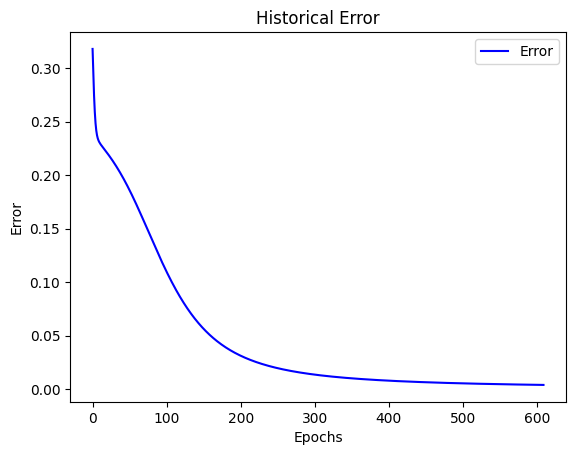

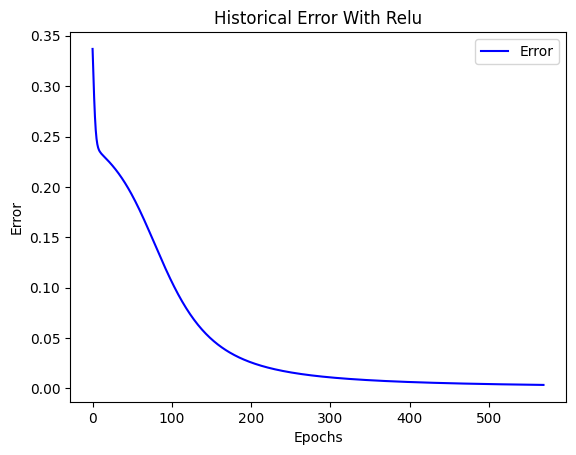

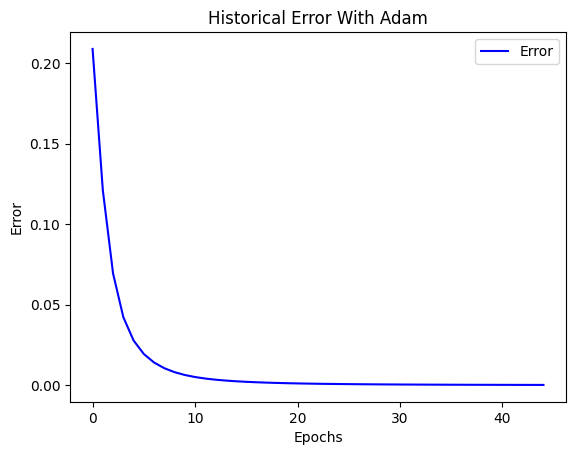

In [ ]:
plt.plot(errors_glcm, c = 'b', label = 'Error')
plt.title('Historical Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

plt.plot(errors2_glcm, c = 'b', label = 'Error')
plt.title('Historical Error With Relu')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

plt.plot(errors3_glcm, c = 'b', label = 'Error')
plt.title('Historical Error With Adam')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

## Plot Historical Error Neural Network (Backpropagation) with Data Non GLCM

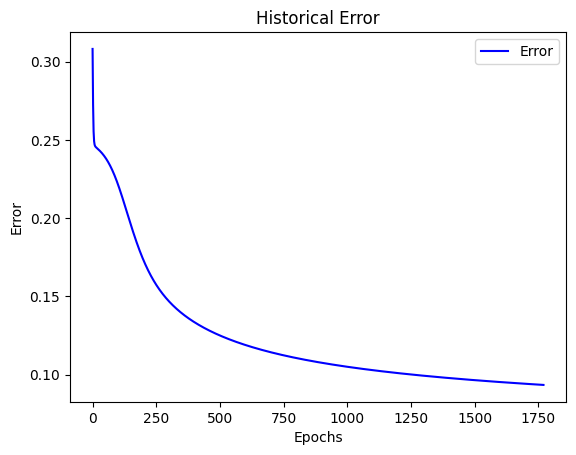

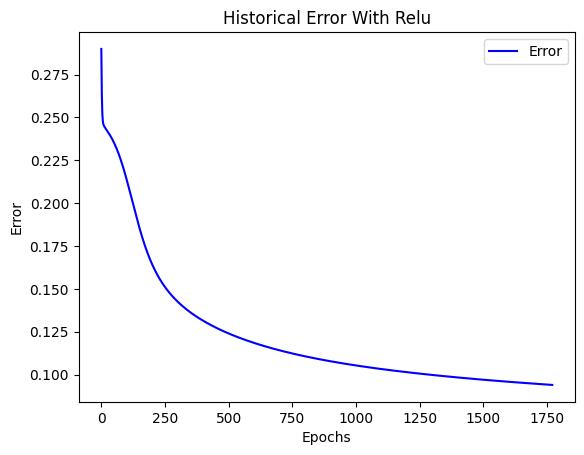

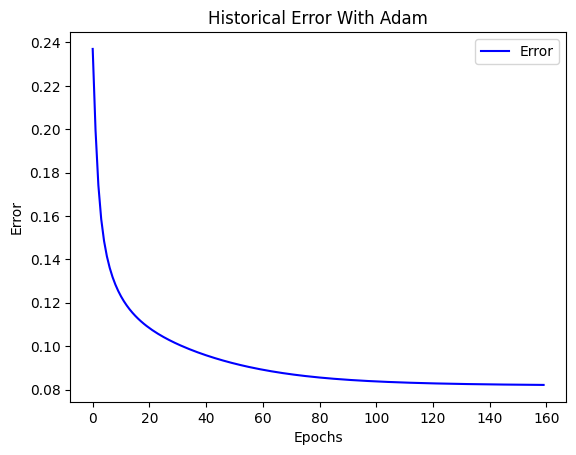

In [ ]:
plt.plot(errors_non_glcm, c = 'b', label = 'Error')
plt.title('Historical Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

plt.plot(errors2_non_glcm, c = 'b', label = 'Error')
plt.title('Historical Error With Relu')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

plt.plot(errors3_non_glcm, c = 'b', label = 'Error')
plt.title('Historical Error With Adam')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

# Comparison

## Comparation With Data GLCM

In [ ]:
# Prediction Backpro
predictions = model_glcm.forward(x_test_std_g)
# Prediction Backpro With Relu
predictions2 = model2_glcm.forward(x_test_std_g)
# Prediction Backpro With Adam
predictions3 = model3_glcm.forward(x_test_std_g)

print("Predicted output: \n" + str(model_glcm.forward(x_test_std_g).T))
print("Prediction Backpro With Relu output: \n" + str(model2_glcm.forward(x_test_std_g).T))
print("Prediction Backpro With Adam output: \n" + str(model3_glcm.forward(x_test_std_g).T))

Predicted output: 
[[0.06513114 0.94915083 0.06513114 0.06513114 0.06571675 0.92537979
  0.92699357 0.95871147 0.06513114 0.98306889 0.97989966 0.91763563
  0.9254914  0.07765343 0.06513114 0.92699357 0.96401229 0.93293448
  0.06513114 0.95971098 0.9716964  0.92143755 0.98526819 0.06513114
  0.06513114 0.06513114 0.96615145 0.96758303 0.94652422 0.06513114
  0.06513114 0.96437737 0.98605433 0.96912683 0.96764953 0.94206231
  0.06513114 0.06513114 0.06513114 0.95393678 0.06513114 0.06513114
  0.067854   0.06513114 0.07249894 0.0663752  0.96668939 0.06513114
  0.06513114 0.98621441 0.06513114 0.06513114 0.92699357 0.06513114
  0.92264399 0.92440811 0.9489981  0.93911861 0.0663817  0.06513114]]
Prediction Backpro With Relu output: 
[[0.06144742 0.94653332 0.06144742 0.06144742 0.06202485 0.92551175
  0.92946733 0.95372478 0.06144742 0.98226081 0.97831695 0.91949384
  0.9270557  0.07375727 0.06144742 0.92946733 0.96129548 0.93221694
  0.06144742 0.95752539 0.96941496 0.92110282 0.98505439 

In [ ]:
# Denormalisasi data prediksi
predicted_1 = []
for i in range(len(predictions)):
    predicted_1.append([predictions[i][0] * (np.max(y_g) - np.min(y_g)) + np.min(y_g)])

# Denormalisasi data prediksi Backpro With Relu
predicted_2 = []
for i in range(len(predictions2)):
    predicted_2.append([predictions2[i][0] * (np.max(y_g) - np.min(y_g)) + np.min(y_g)])

# Denormalisasi data prediksi Backpro With Adam
predicted_3 = []
for i in range(len(predictions3)):
    predicted_3.append([predictions3[i][0] * (np.max(y_g) - np.min(y_g)) + np.min(y_g)])

# Denormalisasi data aktual
actual_1 = []
for i in range(len(y_test_g)):
    actual_1.append([y_test_g[i] * (np.max(y_g) - np.min(y_g)) + np.min(y_g)])

In [ ]:
print("Data Predicted Backpro output: \n" + str(predicted_1))
print("Data Predicted Backpro With Relu output: \n" +  str(predicted_2))
print("Data Predicted Backpro With Adam output: \n" +  str(predicted_3))

print("Data Actual: \n" +  str(actual_1))

Data Predicted Backpro output: 
[[0.06513114003264923], [0.9491508273128696], [0.06513114003264923], [0.06513114003264925], [0.06571675313819085], [0.9253797906328008], [0.9269935678373743], [0.9587114715452255], [0.06513114003264923], [0.9830688911547159], [0.9798996632042403], [0.9176356342936679], [0.925491396738481], [0.07765343362636991], [0.06513114003264925], [0.9269935678373743], [0.9640122908614317], [0.9329344774792737], [0.06513114003264923], [0.9597109843845935], [0.9716964000827432], [0.9214375457205624], [0.9852681883270067], [0.06513114003264925], [0.06513114003264925], [0.06513114003264923], [0.9661514524799467], [0.9675830258206447], [0.9465242190082789], [0.06513114003264923], [0.06513114003264923], [0.9643773677206093], [0.9860543308055931], [0.9691268344408825], [0.9676495309849985], [0.9420623102143527], [0.06513114003264925], [0.06513114003264925], [0.06513114003264923], [0.9539367806331083], [0.06513114003264925], [0.06513114003264925], [0.06785400450625279], [0.

## Comparation With Data Non GLCM

In [ ]:
# Prediction Backpro
predictions_ng = model_non_glcm.forward(x_test_std_ng)
# Prediction Backpro With Relu
predictions2_ng = model2_non_glcm.forward(x_test_std_ng)
# Prediction Backpro With Adam
predictions3_ng = model3_non_glcm.forward(x_test_std_ng)

print("Predicted output: \n" + str(model_non_glcm.forward(x_test_std_ng).T))
print("Prediction Backpro With Relu output: \n" + str(model2_non_glcm.forward(x_test_std_ng).T))
print("Prediction Backpro With Adam output: \n" + str(model3_non_glcm.forward(x_test_std_ng).T))

Predicted output: 
[[0.21117826 0.97950739 0.21117826 0.21117826 0.21645975 0.78295342
  0.21117826 0.99893872 0.21117826 0.99920234 0.99952107 0.48794886
  0.43678625 0.33862895 0.21117826 0.21117826 0.99395366 0.8284577
  0.21117826 0.98400254 0.99727681 0.89316397 0.99946521 0.21117826
  0.21117826 0.21117826 0.99304943 0.99910991 0.936811   0.21117826
  0.21117826 0.99842795 0.99939278 0.99926887 0.99768123 0.99779006
  0.21117826 0.21117826 0.21117826 0.99569633 0.21117826 0.21117826
  0.24044942 0.21117826 0.30943584 0.22335554 0.99451615 0.21117826
  0.21117826 0.99949552 0.21117826 0.21117826 0.21117826 0.21117826
  0.27642572 0.47697619 0.99962065 0.95133535 0.21753153 0.21117826]]
Prediction Backpro With Relu output: 
[[0.21293922 0.98424192 0.21293922 0.21293922 0.21806883 0.77744334
  0.21293922 0.99937888 0.21293922 0.99955383 0.99970704 0.47827655
  0.43072145 0.33883068 0.21293922 0.21293922 0.99633095 0.83181002
  0.21293922 0.9884214  0.99848719 0.89052331 0.99967097 0

In [ ]:
# Denormalisasi data prediksi
predicted_1_ng = []
for i in range(len(predictions_ng)):
    predicted_1_ng.append([predictions_ng[i][0] * (np.max(y_ng) - np.min(y_ng)) + np.min(y_ng)])

# Denormalisasi data prediksi Backpro With Relu
predicted_2_ng = []
for i in range(len(predictions2_ng)):
    predicted_2_ng.append([predictions2_ng[i][0] * (np.max(y_ng) - np.min(y_ng)) + np.min(y_ng)])

# Denormalisasi data prediksi Backpro With Adam
predicted_3_ng = []
for i in range(len(predictions3_ng)):
    predicted_3_ng.append([predictions3_ng[i][0] * (np.max(y_ng) - np.min(y_ng)) + np.min(y_ng)])

# Denormalisasi data aktual
actual_1_ng = []
for i in range(len(y_test_ng)):
    actual_1_ng.append([y_test_ng[i] * (np.max(y_ng) - np.min(y_ng)) + np.min(y_ng)])

In [ ]:
print("Data Predicted Backpro output: \n" + str(predicted_1_ng))
print("Data Predicted Backpro With Relu output: \n" +  str(predicted_2_ng))
print("Data Predicted Backpro With Adam output: \n" +  str(predicted_3_ng))

print("Data Actual: \n" +  str(actual_1_ng))

Data Predicted Backpro output: 
[[0.21117825644723284], [0.9795073946633855], [0.21117825644723284], [0.21117825644723284], [0.21645974936076454], [0.7829534201644919], [0.21117825644723284], [0.998938715268428], [0.21117825644723284], [0.9992023404415682], [0.999521067507236], [0.48794885724894277], [0.43678624604364163], [0.33862895465804016], [0.21117825644723284], [0.21117825644723284], [0.9939536565263177], [0.8284577047688964], [0.21117825644723284], [0.9840025370862474], [0.9972768058176479], [0.8931639660273124], [0.9994652050150562], [0.21117825644723284], [0.21117825644723284], [0.21117825644723284], [0.9930494329266456], [0.9991099146570783], [0.9368110012520798], [0.21117825644723284], [0.21117825644723284], [0.9984279453849757], [0.9993927807133363], [0.999268873407645], [0.9976812300954513], [0.9977900619255177], [0.21117825644723284], [0.21117825644723284], [0.21117825644723284], [0.9956963338060288], [0.21117825644723284], [0.21117825644723284], [0.24044942270486713], [

# Plot Box Comparation Results Backpro

## Plot Box Comparation Results Data GLCM

In [ ]:
predicted_1
predicted_2
predicted_3
actual_1

predicted_1_ng
predicted_2_ng
predicted_3_ng
actual_1_ng

[[0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0]]

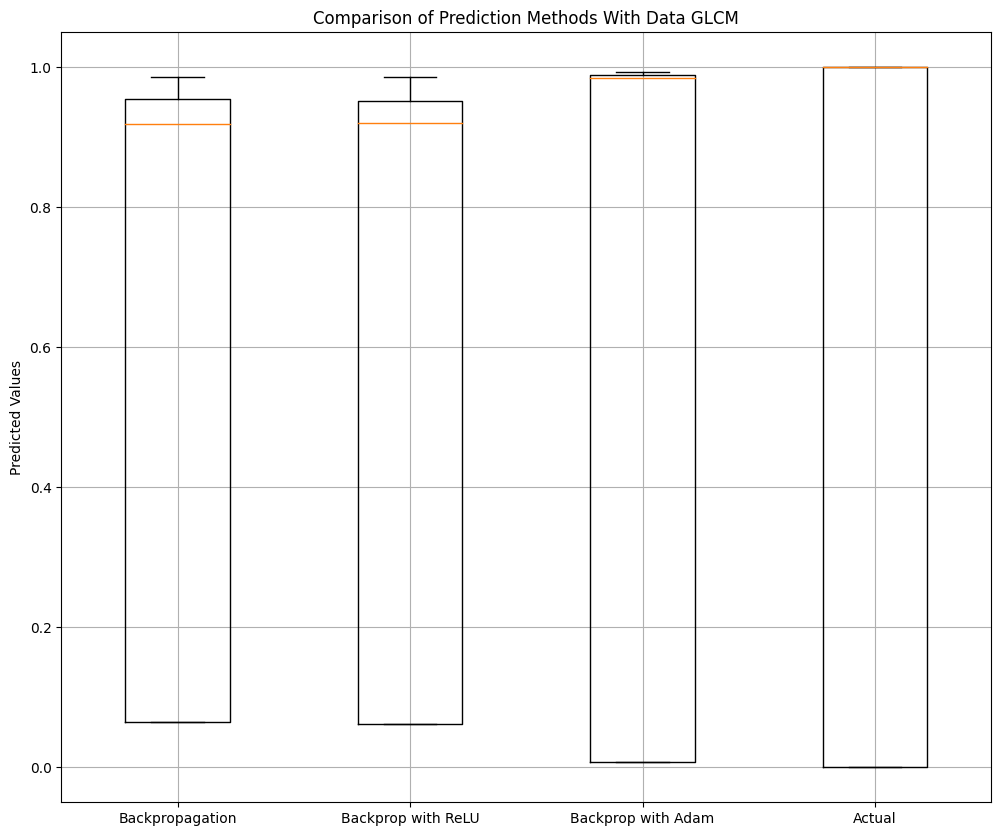

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Flatten the arrays for easier processing
y_pred = np.array(predicted_1).flatten()
y_pred_relu = np.array(predicted_2).flatten()
y_pred_adam = np.array(predicted_3).flatten()
y_val = np.array(actual_1).flatten()

# Prepare the data for plotting
data = [y_pred, y_pred_relu, y_pred_adam, y_val]
labels = ['Backpropagation', 'Backprop with ReLU', 'Backprop with Adam', 'Actual']

# Create a figure and axis for the plot
plt.figure(figsize=(12, 10))
plt.boxplot(data, labels=labels)

# Set plot details
plt.title('Comparison of Prediction Methods With Data GLCM')
plt.ylabel('Predicted Values')
plt.grid(True)

# Show the plot
plt.show()

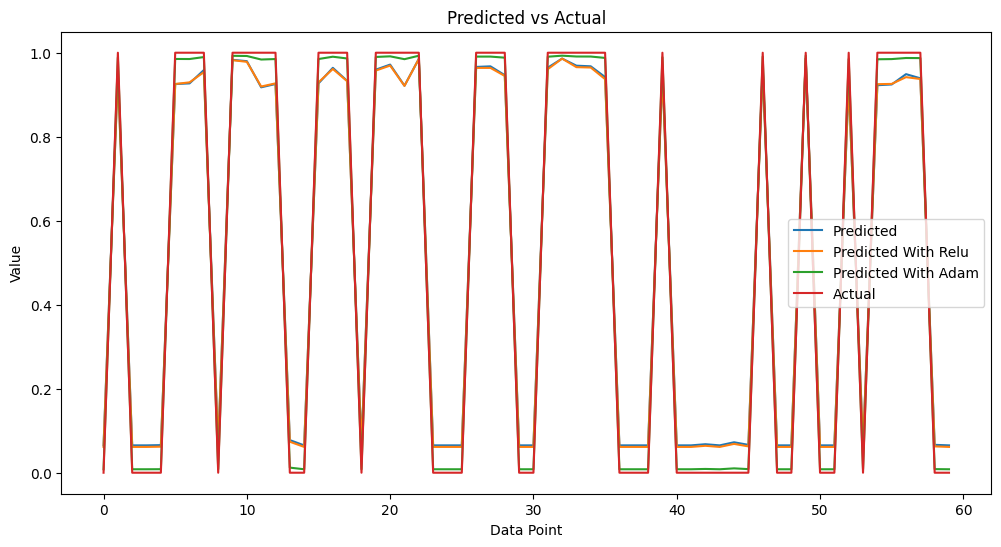

In [ ]:
# Plot hasil prediksi dan data aktual
plt.figure(figsize=(12, 6))
plt.plot(predicted_1, label='Predicted')
plt.plot(predicted_2, label='Predicted With Relu')
plt.plot(predicted_3, label='Predicted With Adam')
plt.plot(actual_1, label='Actual')
plt.title('Predicted vs Actual')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()
plt.show()

## Plot Box Comparation Results Data Non GLCM

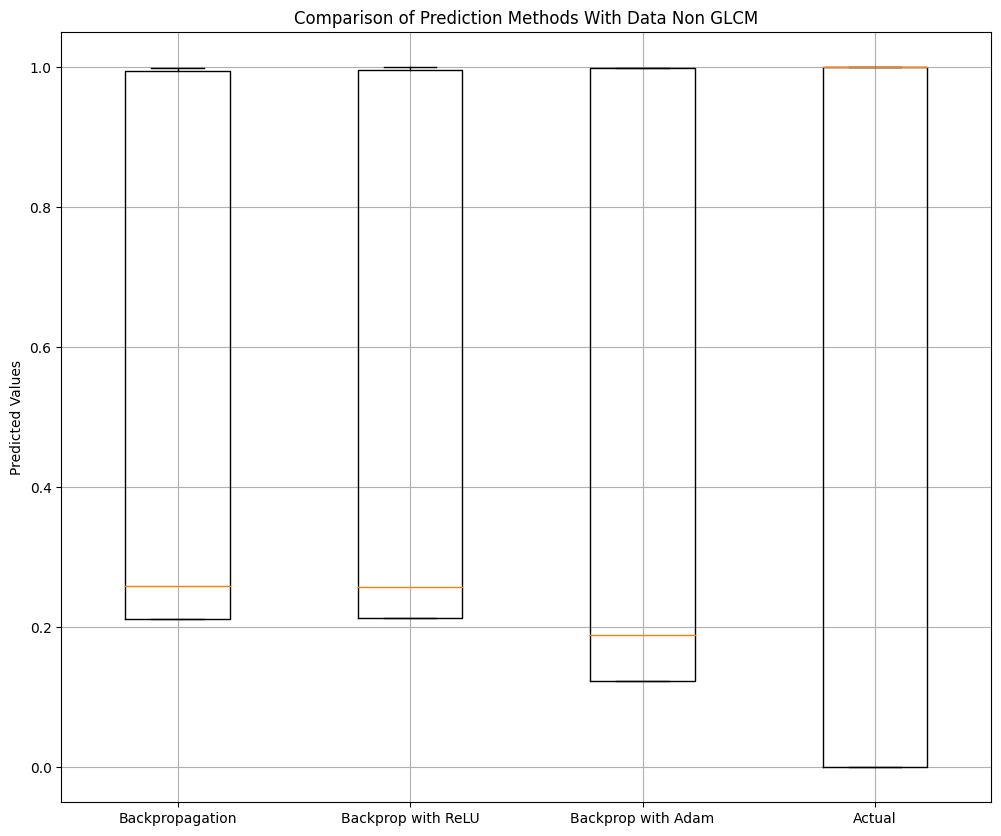

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Flatten the arrays for easier processing
y_pred_ng = np.array(predicted_1_ng).flatten()
y_pred_relu_ng = np.array(predicted_2_ng).flatten()
y_pred_adam_ng = np.array(predicted_3_ng).flatten()
y_val_ng = np.array(actual_1_ng).flatten()

# Prepare the data for plotting
data_ng = [y_pred_ng, y_pred_relu_ng, y_pred_adam_ng, y_val_ng]
labels_ng = ['Backpropagation', 'Backprop with ReLU', 'Backprop with Adam', 'Actual']

# Create a figure and axis for the plot
plt.figure(figsize=(12, 10))
plt.boxplot(data_ng, labels=labels_ng)

# Set plot details
plt.title('Comparison of Prediction Methods With Data Non GLCM')
plt.ylabel('Predicted Values')
plt.grid(True)

# Show the plot
plt.show()

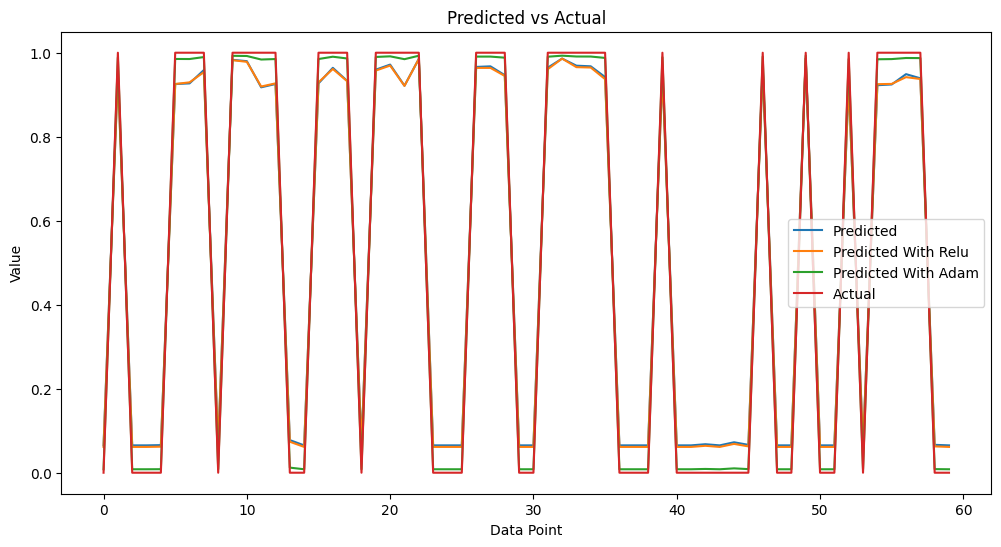

In [ ]:
# Plot hasil prediksi dan data aktual
plt.figure(figsize=(12, 6))
plt.plot(predicted_1, label='Predicted')
plt.plot(predicted_2, label='Predicted With Relu')
plt.plot(predicted_3, label='Predicted With Adam')
plt.plot(actual_1, label='Actual')
plt.title('Predicted vs Actual')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()
plt.show()

## Confusion Matrix GLCM Data

In [ ]:
# Inisialisasi list hasil
y_pred = []
y_pred_relu = []
y_pred_adam = []

for sublist in predicted_1:
    for pred in sublist:
        if pred < 0.5:
            y_pred.append(0)
        else:
            y_pred.append(1)

for sublist in predicted_2:
    for pred in sublist:
        if pred < 0.5:
            y_pred_relu.append(0)
        else:
            y_pred_relu.append(1)

for sublist in predicted_3:
    for pred in sublist:
        if pred < 0.5:
            y_pred_adam.append(0)
        else:
            y_pred_adam.append(1)

y_val = []  # Inisialisasi list hasil

for sublist in actual_1:
    for act in sublist:
        if act < 0.5:
            y_val.append(0)
        else:
            y_val.append(1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Menghitung metrik evaluasi
accuracy = accuracy_score(y_val, y_pred)
accuracy_relu = accuracy_score(y_val, y_pred_relu)
accuracy_adam = accuracy_score(y_val, y_pred_adam)

# Menampilkan hasil
print("Akurasi:", accuracy)
print("Akurasi With Relu:", accuracy_relu)
print("Akurasi With Adam:", accuracy_adam)

Akurasi: 1.0
Akurasi With Relu: 1.0
Akurasi With Adam: 1.0


In [ ]:
data_test = dfng.tail(60)

# Menghilangkan tanda kurung dengan list comprehension
label_g = [x[0] for x in actual_1]

In [ ]:
data_test['Prediksi'] = y_pred
data_test['Prediksi With Relu'] = y_pred_relu
data_test['Prediksi With Adam'] = y_pred_adam
data_test['Label'] = label_g
data_test['Output'] = data_test['Label'].replace({0: 'No', 1: 'Yes'})

# data_test

<ipython-input-226-251d267393ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Prediksi'] = y_pred
<ipython-input-226-251d267393ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Prediksi With Relu'] = y_pred_relu
<ipython-input-226-251d267393ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# List of predictions and their descriptions
predictions = [y_pred, y_pred_relu, y_pred_adam]
descriptions = ['Standard', 'ReLU Activated', 'Adam Optimized']

# Loop through each set of predictions
for pred, desc in zip(predictions, descriptions):
    print(f"\nResults for {desc} Predictions:")

    # Compute the confusion matrix
    confusion = confusion_matrix(y_val, pred)
    print("\nConfusion Matrix:")
    print(confusion)

    # Generate a classification report
    classification_rep = classification_report(y_val, pred, zero_division=0)
    print("\nClassification Report:")
    print(classification_rep)

    # Show TP, TN, FP, FN
    tn, fp, fn, tp = confusion.ravel()
    print("\nTrue Negatives: ", tn)
    print("False Positives: ", fp)
    print("False Negatives: ", fn)
    print("True Positives: ", tp)


Results for Standard Predictions:

Confusion Matrix:
[[29  0]
 [ 0 31]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        31

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


True Negatives:  29
False Positives:  0
False Negatives:  0
True Positives:  31

Results for ReLU Activated Predictions:

Confusion Matrix:
[[29  0]
 [ 0 31]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        31

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


True Negatives:  29
False Positives:  0
False Negatives:  0
True

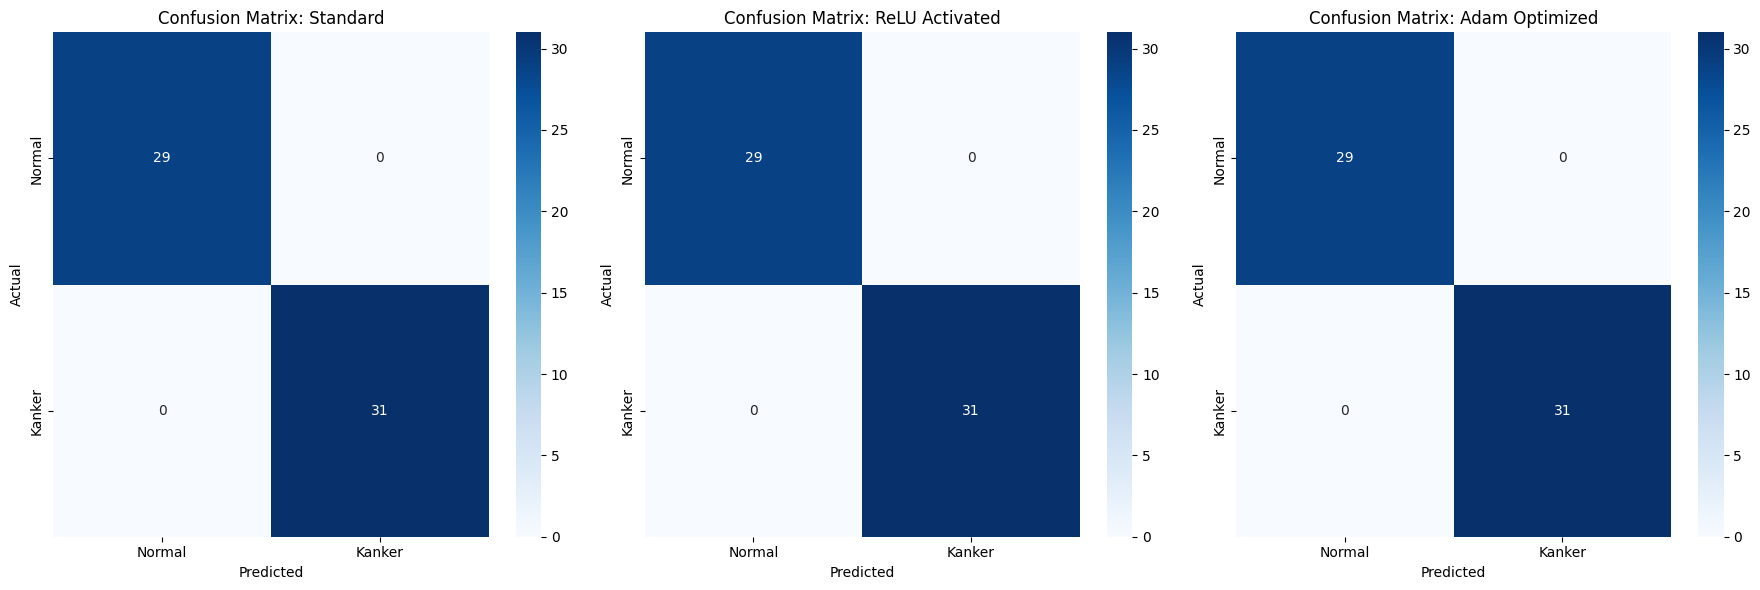

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Data prediksi dan deskripsi masing-masing
predictions = [y_pred, y_pred_relu, y_pred_adam]
descriptions = ['Standard', 'ReLU Activated', 'Adam Optimized']

# Set label names for classes
class_names = ["Normal", "Kanker"]

# Buat figure dan axes untuk subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Sesuaikan dengan jumlah prediksi

# Loop through each set of predictions to plot the confusion matrix
for ax, pred, desc in zip(axes.flatten(), predictions, descriptions):
    # Compute the confusion matrix
    confusion = confusion_matrix(y_val, pred)

    # Plot confusion matrix
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix: {desc}')

# Tampilkan semua plot
plt.tight_layout()
plt.show()


In [ ]:
# import pandas as pd

# # Create a DataFrame to save predictions
# predictions_df = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred, 'Predicted With Relu': y_pred_relu, 'Predicted With Adam': y_pred_adam})
# predictions_df.to_excel('predictions.xlsx', index=False)
# # predictions_df.to_csv('predictions.csv', index=False)

# # Display the DataFrame
# print("\nPredictions saved to 'predictions.xlsx':")

# # Mengubah opsi tampilan pandas
# pd.set_option('display.max_rows', None)
# print(predictions_df)

# # Now you can access TP, TN, FN, FP, and the predictions saved in 'predictions.csv' for further analysis or reporting.


In [ ]:
# from google.colab import files
# files.download('predictions.xlsx')

## Confusion Matrix With Non GLCM Data

In [ ]:

# Inisialisasi list hasil
y_pred_ng = []
y_pred_relu_ng = []
y_pred_adam_ng = []

for sublist in predicted_1_ng:
    for pred in sublist:
        if pred < 0.5:
            y_pred_ng.append(0)
        else:
            y_pred_ng.append(1)

for sublist in predicted_2_ng:
    for pred in sublist:
        if pred < 0.5:
            y_pred_relu_ng.append(0)
        else:
            y_pred_relu_ng.append(1)

for sublist in predicted_3_ng:
    for pred in sublist:
        if pred < 0.5:
            y_pred_adam_ng.append(0)
        else:
            y_pred_adam_ng.append(1)

y_val_ng = []  # Inisialisasi list hasil

for sublist in actual_1_ng:
    for act in sublist:
        if act < 0.5:
            y_val_ng.append(0)
        else:
            y_val_ng.append(1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Menghitung metrik evaluasi
accuracy_ng = accuracy_score(y_val_ng, y_pred_ng)
accuracy_relu_ng = accuracy_score(y_val_ng, y_pred_relu_ng)
accuracy_adam_ng = accuracy_score(y_val_ng, y_pred_adam_ng)

# Menampilkan hasil
print("Akurasi:", accuracy_ng)
print("Akurasi With Relu:", accuracy_relu_ng)
print("Akurasi With Adam:", accuracy_adam_ng)

Akurasi: 0.8833333333333333
Akurasi With Relu: 0.8833333333333333
Akurasi With Adam: 0.9166666666666666


In [ ]:
data_test_ng = dfng.tail(60)

# Menghilangkan tanda kurung dengan list comprehension
label_ng = [x[0] for x in actual_1_ng]

In [ ]:
data_test_ng['Prediksi'] = y_pred_ng
data_test_ng['Prediksi With Relu'] = y_pred_relu_ng
data_test_ng['Prediksi With Adam'] = y_pred_adam_ng
data_test_ng['Label'] = label_ng
data_test_ng['Output'] = data_test_ng['Label'].replace({0: 'No', 1: 'Yes'})

data_test_ng

<ipython-input-234-90273fd4bc9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_ng['Prediksi'] = y_pred_ng
<ipython-input-234-90273fd4bc9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_ng['Prediksi With Relu'] = y_pred_relu_ng
<ipython-input-234-90273fd4bc9b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,Energy,Contrast,Homogeneity,Entropy,Label,Prediksi,Prediksi With Relu,Prediksi With Adam,Output
140,0.0,0.000000,1.000000,6.126592e-07,0,0,0,0,No
141,21.0,12.165466,0.999893,1.793942e-03,1,1,1,1,Yes
142,4.0,2.111116,0.999968,3.686363e-04,0,0,0,0,No
143,30.0,19.529762,0.999950,2.737593e-03,0,0,0,0,No
144,0.0,0.000000,1.000000,6.126592e-07,0,0,0,0,No
145,0.0,0.000000,1.000000,6.126592e-07,1,1,1,1,Yes
146,0.0,0.000000,1.000000,6.126592e-07,1,0,0,0,Yes
147,0.0,0.000000,1.000000,6.126592e-07,1,1,1,1,Yes
148,8.0,25.428945,0.999706,3.461338e-03,0,0,0,0,No
149,8.0,4.924597,0.999887,7.949815e-04,1,1,1,1,Yes


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# List of predictions and their descriptions
predictions_ng = [y_pred_ng, y_pred_relu_ng, y_pred_adam_ng]
descriptions_ng = ['Standard', 'ReLU Activated', 'Adam Optimized']

# Loop through each set of predictions
for pred, desc in zip(predictions_ng, descriptions_ng):
    print(f"\nResults for {desc} Predictions:")

    # Compute the confusion matrix
    confusion = confusion_matrix(y_val_ng, pred)
    print("\nConfusion Matrix:")
    print(confusion)

    # Generate a classification report
    classification_rep_ng = classification_report(y_val_ng, pred, zero_division=0)
    print("\nClassification Report:")
    print(classification_rep_ng)

    # Show TP, TN, FP, FN
    tn, fp, fn, tp = confusion.ravel()
    print("\nTrue Negatives: ", tn)
    print("False Positives: ", fp)
    print("False Negatives: ", fn)
    print("True Positives: ", tp)


Results for Standard Predictions:

Confusion Matrix:
[[29  0]
 [ 7 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        29
           1       1.00      0.77      0.87        31

    accuracy                           0.88        60
   macro avg       0.90      0.89      0.88        60
weighted avg       0.91      0.88      0.88        60


True Negatives:  29
False Positives:  0
False Negatives:  7
True Positives:  24

Results for ReLU Activated Predictions:

Confusion Matrix:
[[29  0]
 [ 7 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        29
           1       1.00      0.77      0.87        31

    accuracy                           0.88        60
   macro avg       0.90      0.89      0.88        60
weighted avg       0.91      0.88      0.88        60


True Negatives:  29
False Positives:  0
False Negatives:  7
True

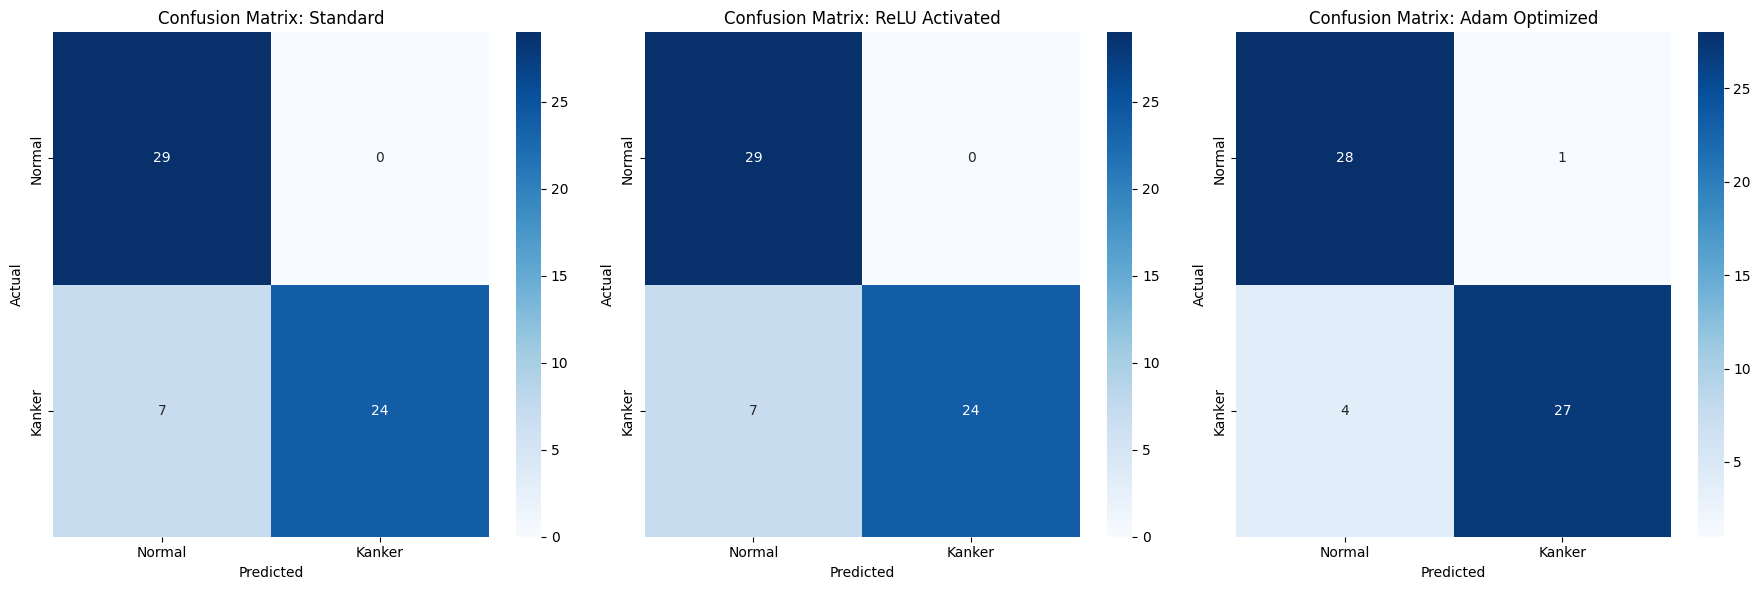

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Data prediksi dan deskripsi masing-masing
predictions_ng = [y_pred_ng, y_pred_relu_ng, y_pred_adam_ng]
descriptions_ng = ['Standard', 'ReLU Activated', 'Adam Optimized']

# Set label names for classes
class_names = ["Normal", "Kanker"]

# Buat figure dan axes untuk subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Sesuaikan dengan jumlah prediksi

# Loop through each set of predictions_ng to plot the confusion matrix
for ax, pred, desc in zip(axes.flatten(), predictions_ng, descriptions_ng):
    # Compute the confusion matrix
    confusion_ng = confusion_matrix(y_val, pred)

    # Plot confusion matrix
    sns.heatmap(confusion_ng, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix: {desc}')

# Tampilkan semua plot
plt.tight_layout()
plt.show()
